In [22]:
import glob
import torch
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.calibration import calibration_curve


In [25]:

def load_results(result_paths):
    lbs = masks = None
    preds_list = list()
    variances_list = list()

    for test_result_path in result_paths:
        results = torch.load(test_result_path)

        if lbs is not None:
            assert (lbs == results['lbs']).all()
        else:
            lbs: np.ndarray = results['lbs']

        if masks is not None:
            assert (masks == results['masks']).all()
        else:
            masks: np.ndarray = results['masks']

        preds_list.append(results['preds']['preds'])
        try:
            variances_list.append(results['preds']['vars'])
        except KeyError:
            pass

    # aggregate mean and variance
    preds = np.stack(preds_list).mean(axis=0)
    if variances_list:  # regression
        # variances = np.mean(np.stack(preds_list) ** 2 + np.stack(variances_list), axis=0) - preds ** 2
        variances = np.stack(variances_list).mean(axis=0)
    else:
        variances = None

    return preds, variances, lbs, masks


In [56]:
data_name = 'tox21'
model_name = 'DNN-rdkit'
none_result_dir = f'../output/{data_name}/{model_name}/none/seed-0/preds/'
focal_result_dir = f'../output/{data_name}/{model_name}/FocalLoss/seed-0/preds/'
ts_result_dir = f'../output/{data_name}/{model_name}/TemperatureScaling/seed-0/preds/'
mc_result_dir = f'../output/{data_name}/{model_name}/MCDropout/seed-0/preds/'


In [57]:
none_result_paths = glob.glob(op.join(none_result_dir, "*"))
focal_result_paths = glob.glob(op.join(focal_result_dir, "*"))
ts_result_paths = glob.glob(op.join(ts_result_dir, "*"))
mc_result_paths = glob.glob(op.join(mc_result_dir, "*"))

In [58]:

none_preds, _, lbs, masks = load_results(none_result_paths)
focal_preds, _, lbs, masks = load_results(focal_result_paths)
ts_preds, _, lbs, masks = load_results(ts_result_paths)
mc_preds, _, lbs, masks = load_results(mc_result_paths)

bool_masks = masks.astype(bool)

none_preds = none_preds[bool_masks]
focal_preds = focal_preds[bool_masks]
ts_preds = ts_preds[bool_masks]
mc_preds = mc_preds[bool_masks]
lbs = lbs[bool_masks]

In [59]:
y_none, x_none = calibration_curve(lbs, none_preds, n_bins=15)
y_focal, x_focal = calibration_curve(lbs, focal_preds, n_bins=15)
y_ts, x_ts = calibration_curve(lbs, ts_preds, n_bins=15)
y_mc, x_mc = calibration_curve(lbs, mc_preds, n_bins=15)


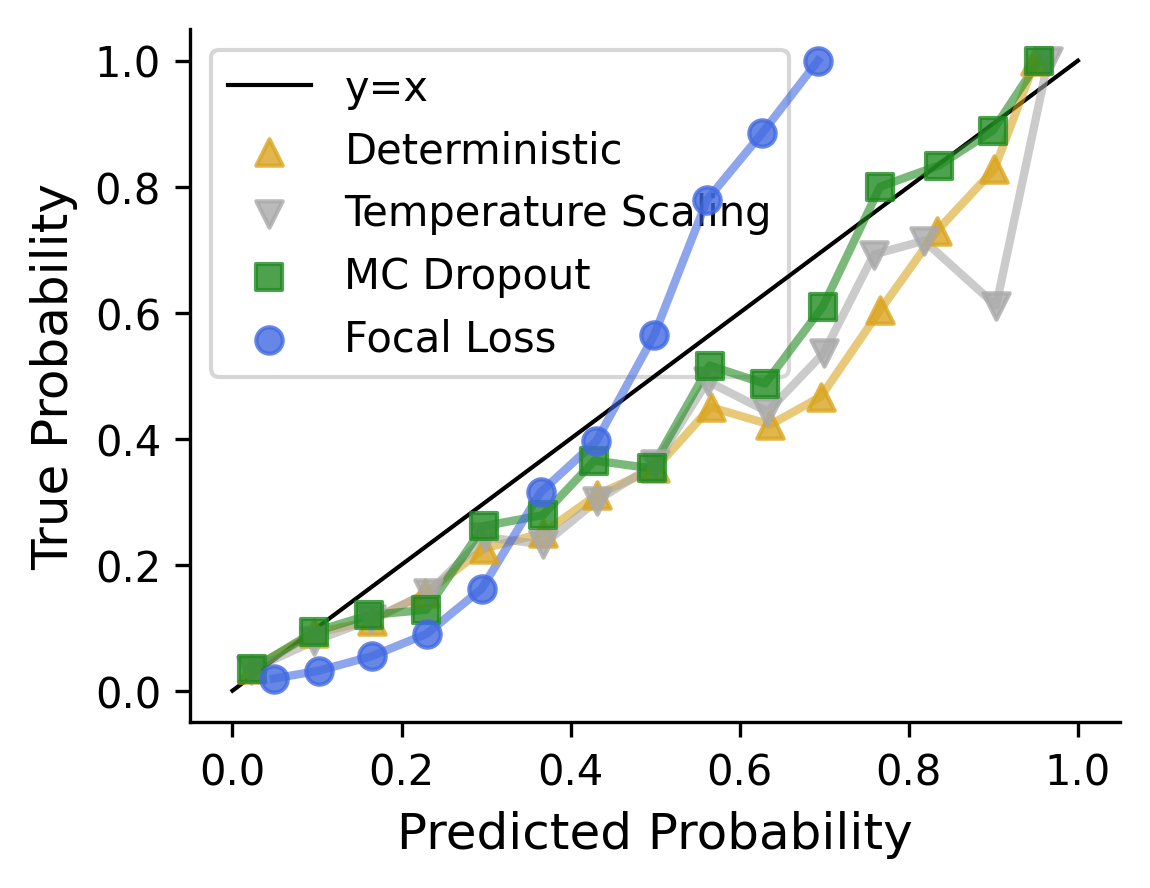

In [60]:
fig, ax = plt.subplots(figsize=(4,3), dpi=300)

ref_x = np.linspace(0, 1, 100)

ax.plot(ref_x, ref_x, color='black', alpha=1, linewidth=1, zorder=10, label="y=x")

ax.plot(x_none, y_none, color='goldenrod', alpha=0.6, linewidth=2, zorder=10)
ax.scatter(x_none, y_none, color='goldenrod', marker='^', s=40, alpha=0.8, zorder=100, label="Deterministic")

ax.plot(x_ts, y_ts, color='darkgray', alpha=0.6, linewidth=2, zorder=10)
ax.scatter(x_ts, y_ts, color='darkgray', marker='v', s=40, alpha=0.8, zorder=100, label="Temperature Scaling")

ax.plot(x_mc, y_mc, color='forestgreen', alpha=0.6, linewidth=2, zorder=10)
ax.scatter(x_mc, y_mc, color='forestgreen', marker='s', s=40, alpha=0.8, zorder=100, label="MC Dropout")

ax.plot(x_focal, y_focal, color='royalblue', alpha=0.6, linewidth=2, zorder=10)
ax.scatter(x_focal, y_focal, color='royalblue', s=40, alpha=0.8, zorder=100, label="Focal Loss")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Predicted Probability', fontsize=12)
ax.set_ylabel('True Probability', fontsize=12)
plt.legend()

f_name = f's5.focal.cal.{model_name}.{data_name}.pdf'
fig.savefig(f_name, bbox_inches='tight')